In [1]:
import torch
import pandas as pd
import numpy as np
from models.resnetv2 import ResNet50, ResNet101
from torchvision import datasets, transforms
from PIL import Image
import torch.utils.data as data
from melanoma.melanoma_loader import Melanoma_loader
import matplotlib.pyplot as plt

# UTILS

In [2]:
from utils import stacked_img, iterate_class

# END UTILS

In [3]:
# melanoma model
# !wget -O model_melanoma https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0

In [4]:
path_to_model = 'model_melanoma'

In [5]:
model = ResNet50(out_features = 2, freeze = True, in_channels = 3)
checkpoint1 = torch.load(path_to_model, map_location='cpu')
msg1 = model.load_state_dict(checkpoint1['model'], strict=False)
msg1

<All keys matched successfully>

In [6]:
dataset = Melanoma_loader(root = "data/train/train", ann_path = "melanoma/data/test_set.csv", 
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [275]:
is_melanoma = 1
generator = iterate_class(dataset, is_melanoma)

model = model.eval()

In [216]:
test_tensor, path = next(generator)

## LRP

In [217]:
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient

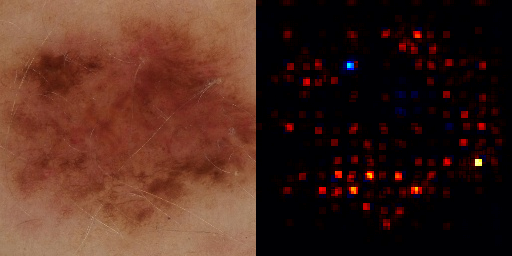

In [218]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# target = torch.eye(2)[[img[1]]] * out[0, 1]
target = torch.eye(2)[[is_melanoma]]
# https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(test_tensor, target)
    
from zennit.image import imgify
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')
new_img = stacked_img(path, img)
# show the image
display(new_img)

In [219]:
model

ResNet50(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

LRP explained: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf

# CRP

In [220]:
from HackedZennit import get_canonizer
from crp.attribution import CondAttribution
attribution = CondAttribution(model)

In [276]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.eval()


sample, path = next(generator)
sample.requires_grad = True # This is not enough if you have multiple conditions 

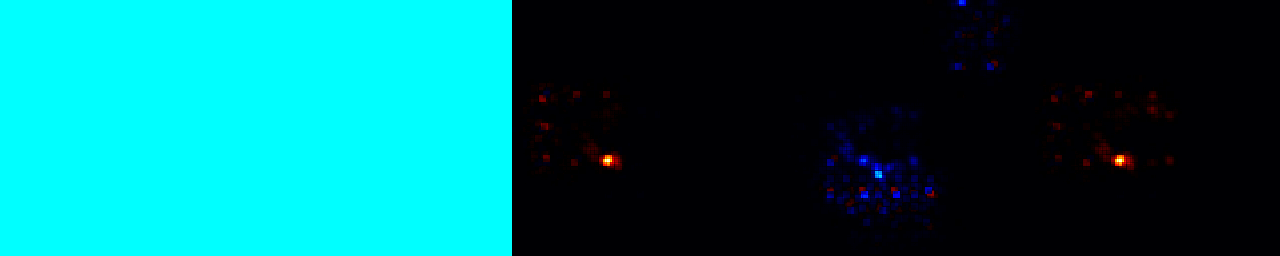

In [277]:
from crp.helper import get_layer_names
from crp.image import imgify

concept_ids = [0, 1, 10, 15, 32] # those are no of channels which we look at (used to define conditions)
conditions = [{'backbone.layer4.2.conv3': [ids], 'y': [is_melanoma]} for ids in concept_ids]
# MUST ALWAYS HAVE LINE LIKE ONE BELOW - HACK
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
# - in crp/attribution.py:CondAttribution.__call__ they duplicate data which removes grad requirement from copies
# WORKAROUND: in the __call__ function mentioned above add data.requires_grad = True before self.check_arguments
# or never pass a list of conditions
heatmaps, act, rel, _ = attribution(sample, conditions, composite)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
display(img)

Those all light blue images are 0 images - these channels have 0 relevance under current parameters.

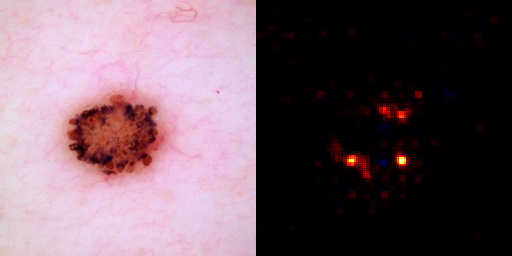

(512, 256)


In [278]:
conditions = [{'y': [is_melanoma]}]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
sample.requires_grad = True
heatmaps, act, rel, _ = attribution(sample, conditions, composite)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
                                                       
new_img = stacked_img(path, img)

display(new_img)
print(new_img.size)

# CRP Concepts

In [279]:
from crp.concepts import ChannelConcept

cc = ChannelConcept()
from crp.helper import get_layer_names

layer_name = 'backbone.layer4.2.conv3'

conditions = [{'y': [is_melanoma]}]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
attr = attribution(sample, conditions, composite, record_layer=[layer_name])

attr.activations[layer_name].shape, attr.relevances[layer_name].shape
# attr[1]["features.40"].shape, attr[2]["features.40"].shape # is equivalent


(torch.Size([1, 2048, 8, 8]), torch.Size([1, 2048, 8, 8]))

In [280]:
rel_c = cc.attribute(attr.relevances[layer_name], abs_norm=True)
rel_c.shape

torch.Size([1, 2048])

In [281]:
from crp.helper import abs_norm

# the six most relevant concepts and their contribution to final classification in percent
concept_ids = torch.argsort(rel_c[0], descending=True)[:6]
concept_ids, rel_c[0, concept_ids]*100

(tensor([ 916, 1517,  860, 1628,  167,  565]),
 tensor([2.1944, 1.3536, 1.3029, 1.2560, 1.2559, 1.2542]))

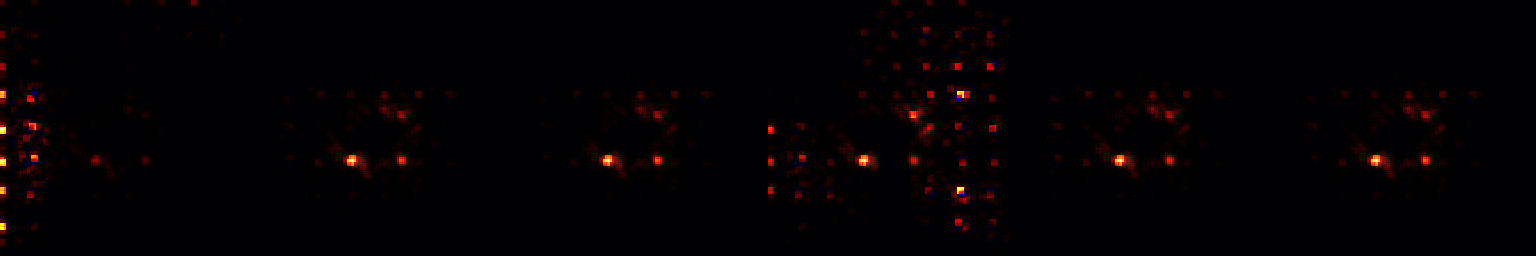

In [282]:
conditions = [{layer_name: [id], 'y': [is_melanoma]} for id in concept_ids]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, cmap='coldnhot', grid=(1, len(concept_ids)))

(256, 256, 3)


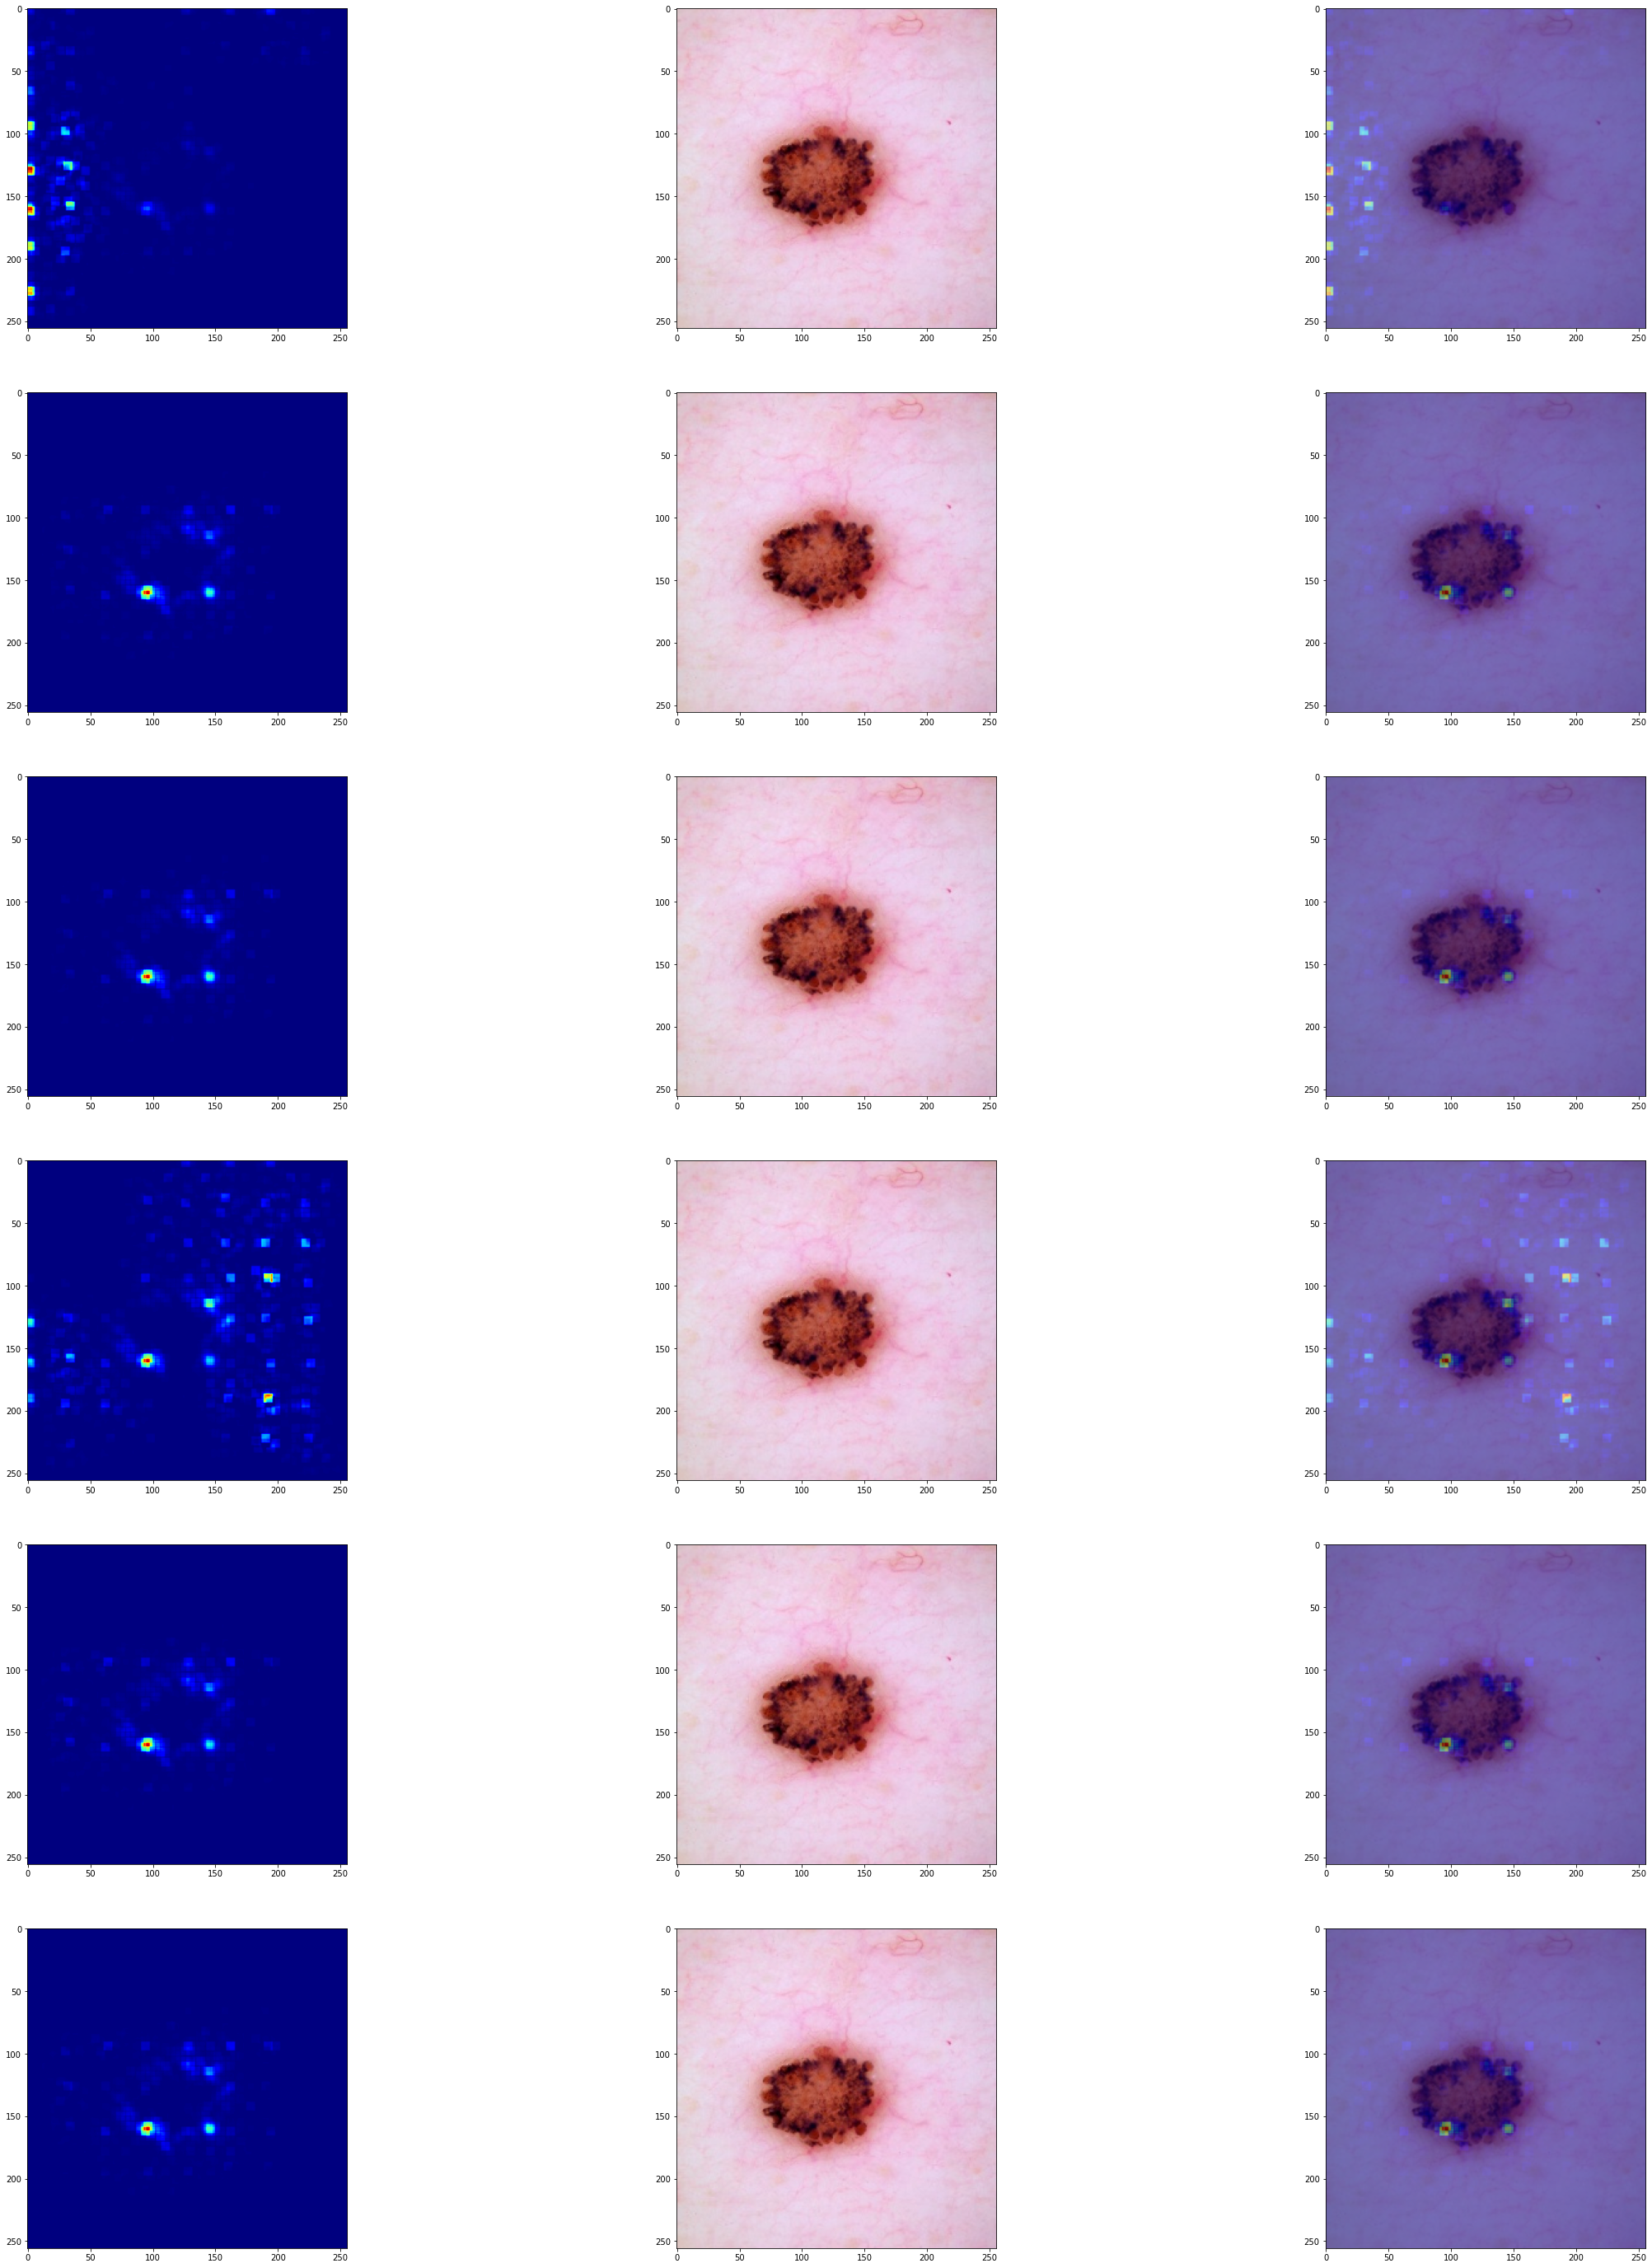

In [283]:
img = np.array(Image.open("data/train/train/" + path + ".jpg"))
print(img.shape)
# load or compute some features
h, w, _ = img.shape

fig, axs = plt.subplots(6, 3)
for i in range(6):
    feature = np.array(heatmap[i])
    feature = np.clip(feature, 0, 1000)
    feature = (255.5 * feature / np.amax(feature)).astype(np.uint8)
    # compute heated image
    alpha = 0.5; img_feature = ((plt.cm.jet(feature)[:, :, :3] * 255) * alpha + img * (1 - alpha)).astype(np.uint8)
    # show images
    axs[i, 0].imshow(feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
    axs[i, 1].imshow(img)
    axs[i, 2].imshow(img_feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
plt.show()

In [284]:
heatmap.size()

torch.Size([6, 256, 256])

# CRP concepts with mask

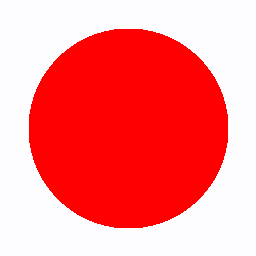

In [190]:
from skimage.draw import disk
mask = torch.zeros(256, 256).to(attribution.device)
row = 128
col = 128
radius = 100
rr, cc = disk((row, col), radius)
mask[rr, cc] = 1

imgify(mask, symmetric=True)


In [191]:
conditions = [{layer_name: [id], 'y': [is_melanoma]} for id in np.arange(0, 2048)]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))
rel_c = []
for attr in attribution.generate(sample, conditions, composite, record_layer=[layer_name], batch_size=10):
    
    masked = attr.heatmap * mask[None, :, :]
    rel_c.append(torch.sum(masked, dim=(1, 2)))

rel_c = torch.cat(rel_c)
print(rel_c)
indices = torch.argsort(rel_c, descending=True)[:5]
# we norm here, so that we clearly see the contribution inside the masked region as percentage
indices, abs_norm(rel_c)[indices]*100

100%|█████████████████████████████████████████| 205/205 [12:36<00:00,  3.69s/it]

tensor([1.2685e-04, 1.3193e-06, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])


(tensor([1139, 1237, 1457,  864,   42]),
 tensor([6.0226, 2.9846, 2.9063, 2.4843, 1.5185]))

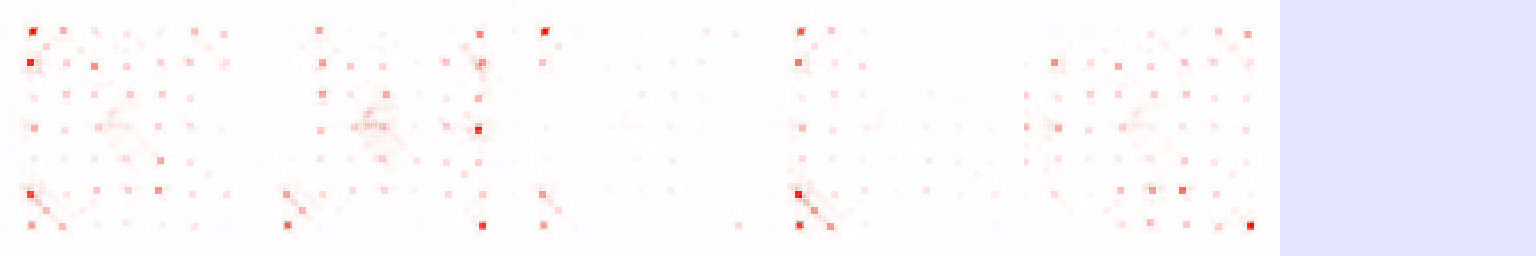

In [192]:
conditions = [{layer_name: [id], 'y': [is_melanoma]} for id in indices]
composite = EpsilonPlusFlat(canonizers=get_canonizer(conditions))

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True,  grid=(1, len(concept_ids)))

In [193]:

plt.rcParams["figure.figsize"] = (40,50)

(256, 256, 3)


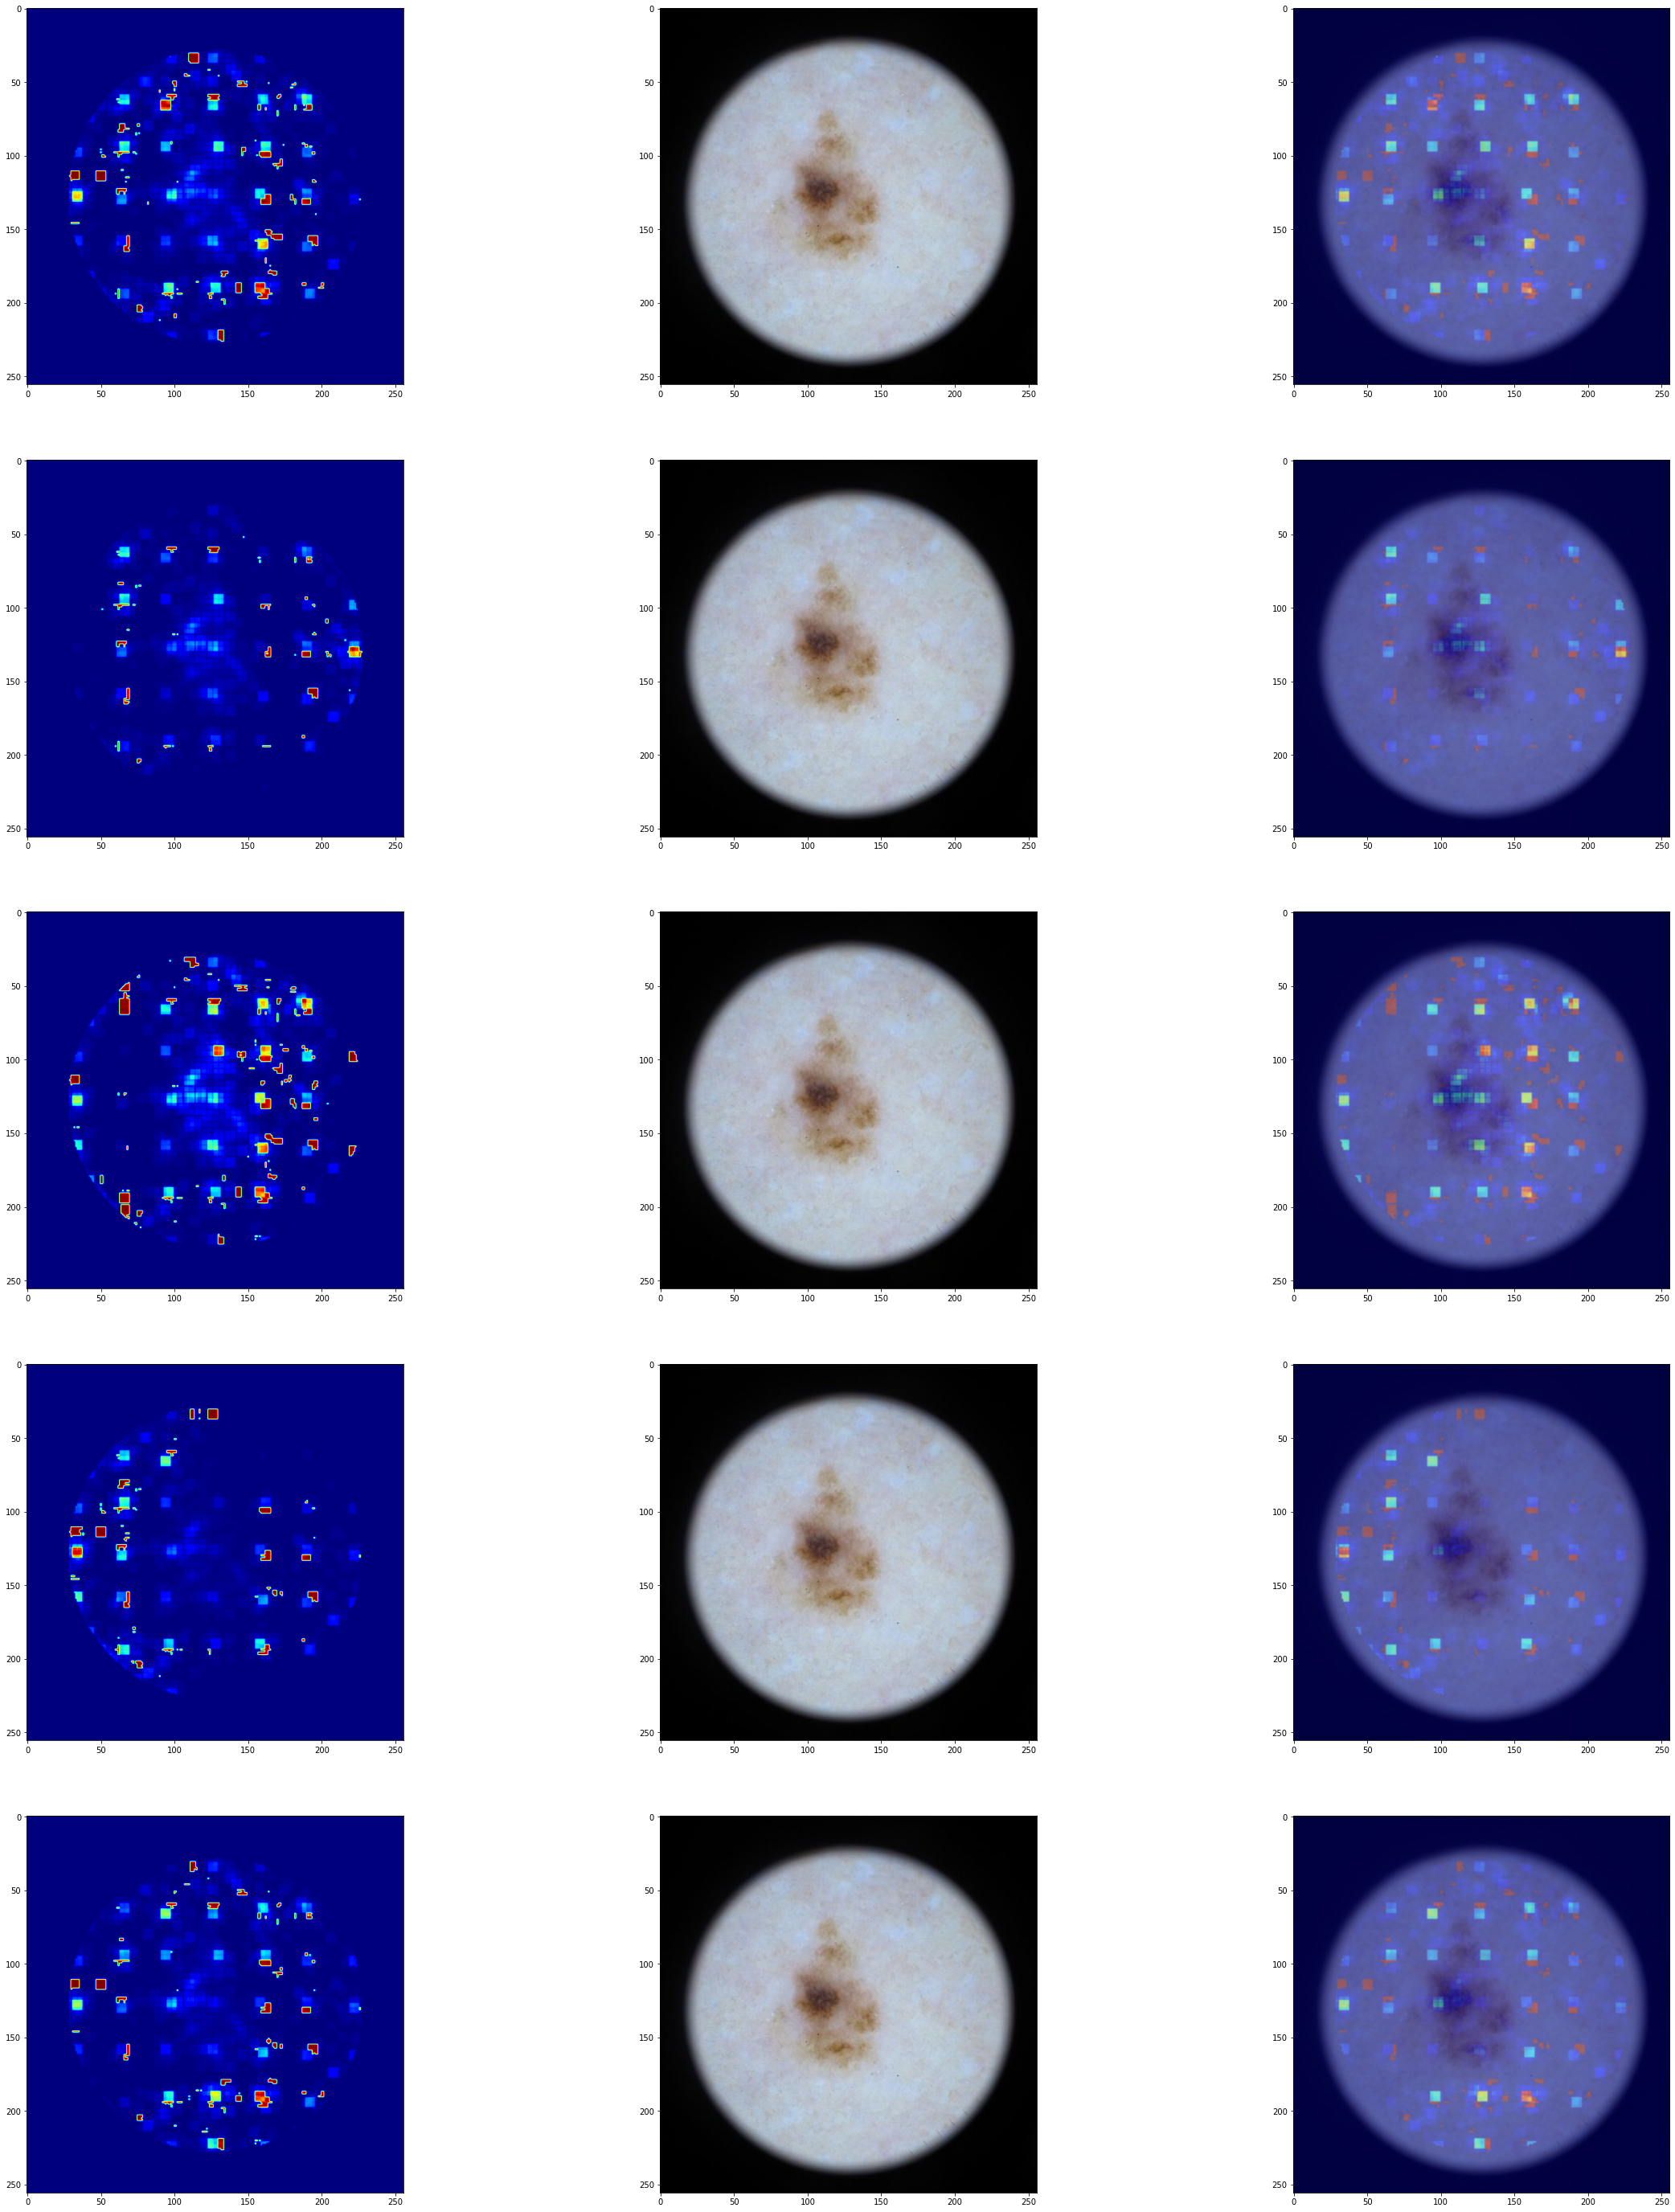

In [197]:
img = np.array(Image.open("data/train/train/" + path + ".jpg"))
print(img.shape)
# load or compute some features
h, w, _ = img.shape
mg = np.mgrid[:h, :w]

fig, axs = plt.subplots(5, 3)
for i in range(5):
    feature = np.array(heatmap[i] * mask)
    feature = (255.5 * feature / np.amax(feature)).astype(np.uint8)
    # compute heated image
    alpha = 0.5; img_feature = ((plt.cm.jet(feature)[:, :, :3] * 255) * alpha + img * (1 - alpha)).astype(np.uint8)
    # show images
    axs[i, 0].imshow(feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
    axs[i, 1].imshow(img)
    axs[i, 2].imshow(img_feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
plt.show()

In [195]:
heatmap.size()

torch.Size([5, 256, 256])

In [196]:
sample.size()

torch.Size([1, 3, 256, 256])